In [10]:
import argparse
import math
import json
import os
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim


from utils import setup_for_distributed, MetricLogger, SmoothedValue, load_model, save_model
from sklearn.model_selection import train_test_split
import models_adapter
from video_dataset import VideoDataset
import pandas as pd
from configs import DATASETS

In [3]:
def get_plt_and_best_epoch(model_name, dataset):
    file_path = f'/hahmwj/expand_tube_st_adapter/trained_weight/{model_name}/{dataset}/log.txt'

    train_acc = []
    val_acc = []
    train_loss = []
    i = 0
    # 파일 열기
    with open(file_path, 'r', encoding='utf-8') as file:
        # 파일의 각 줄을 순회하면서 데이터 추출
        for line in file:
            # JSON 형식의 라인을 파싱
            data = json.loads(line)

            if i > 99:
                break
            # 데이터 추출 및 저장
            train_acc.append(data.get("train_acc1"))
            i+=1
            val_acc.append(data.get("val_acc1"))
            train_loss.append(data.get("train_loss"))


    # 최대값 및 최소값의 인덱스 구하기
    max_train_acc_epoch = train_acc.index(max(train_acc))
    max_val_acc_epoch = val_acc.index(max(val_acc))
    min_train_loss_epoch = train_loss.index(min(train_loss))

    # 최대값 및 최소값 출력
    print(f'Model_name: {model_name}    Dataset: {dataset}')
    print(f'Max Train Accuracy: {max(train_acc)} at Epoch {max_train_acc_epoch}')
    print(f'Max Validation Accuracy: {max(val_acc)} at Epoch {max_val_acc_epoch}')
    print(f'Min Train Loss: {min(train_loss)} at Epoch {min_train_loss_epoch}')

    # 그래프 그리기
    epochs = range(1, len(train_acc) + 1)

    # 병렬 그래프
    fig, ax1 = plt.subplots(figsize=(10, 6))
    # Train Accuracy 그래프 (파랑)
    ax1.plot(epochs, train_acc, label='Train Accuracy', color='blue')
    # Validation Accuracy 그래프 (빨강)
    ax1.plot(epochs, val_acc, label='Validation Accuracy', color='red')

    # 첫 번째 y 축 레이블 설정
    ax1.set_ylabel('Accuracy', color='black')
    ax1.tick_params('y', colors='black')

    # 두 번째 y 축 (왼쪽)을 생성
    ax2 = ax1.twinx()
    # Train Loss 그래프 (초록)
    ax2.plot(epochs, train_loss, label='Train Loss', color='green')

    # 두 번째 y 축 레이블 설정
    ax2.set_ylabel('Loss', color='black')
    ax2.tick_params('y', colors='black')

    # 범례 추가
    ax1.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.85))

    plt.tight_layout()
    # 그래프 제목 및 x 축 레이블 추가
    plt.title(f'{model_name} {dataset} Over Epochs')
    plt.xlabel('Epochs')

    plt.savefig(f'/hahmwj/expand_tube_st_adapter/trained_weight/Result_plot/{model_name}_{dataset}.png',  bbox_inches='tight')
    # 그래프 표시
    plt.show()
    

## Train val loss per epoches

Model_name: st_adapter    Dataset: hmdb
Max Train Accuracy: 95.17870368780913 at Epoch 89
Max Validation Accuracy: 83.41056533827619 at Epoch 40
Min Train Loss: 0.1799042251099039 at Epoch 97


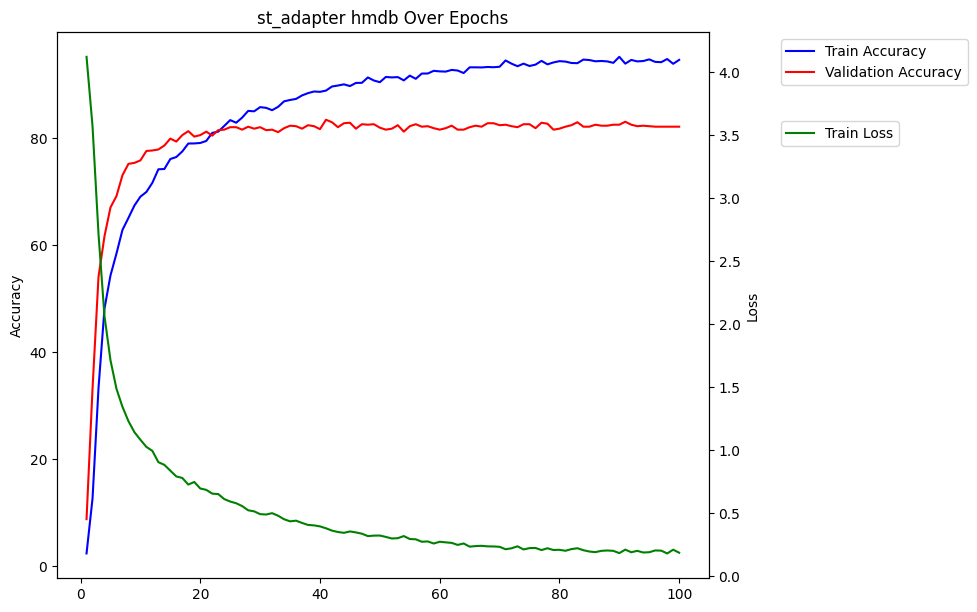

Model_name: st_adapter    Dataset: ucf
Max Train Accuracy: 98.9817415730337 at Epoch 80
Max Validation Accuracy: 99.62476547842401 at Epoch 76
Min Train Loss: 0.03660992201827972 at Epoch 90


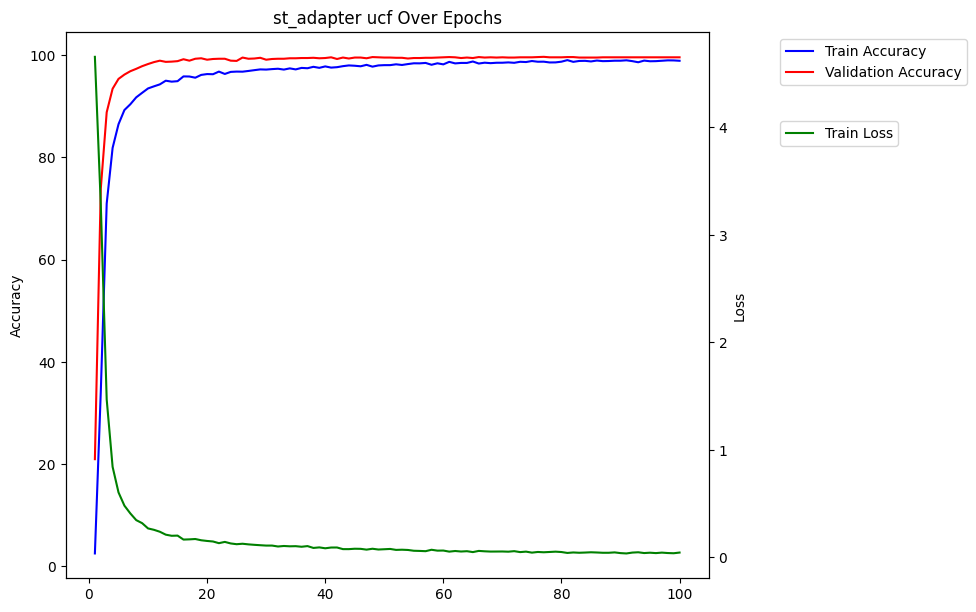

Model_name: expand_st_adapter    Dataset: hmdb
Max Train Accuracy: 79.01481478302567 at Epoch 82
Max Validation Accuracy: 66.91380908248378 at Epoch 67
Min Train Loss: 0.7220664440481751 at Epoch 92


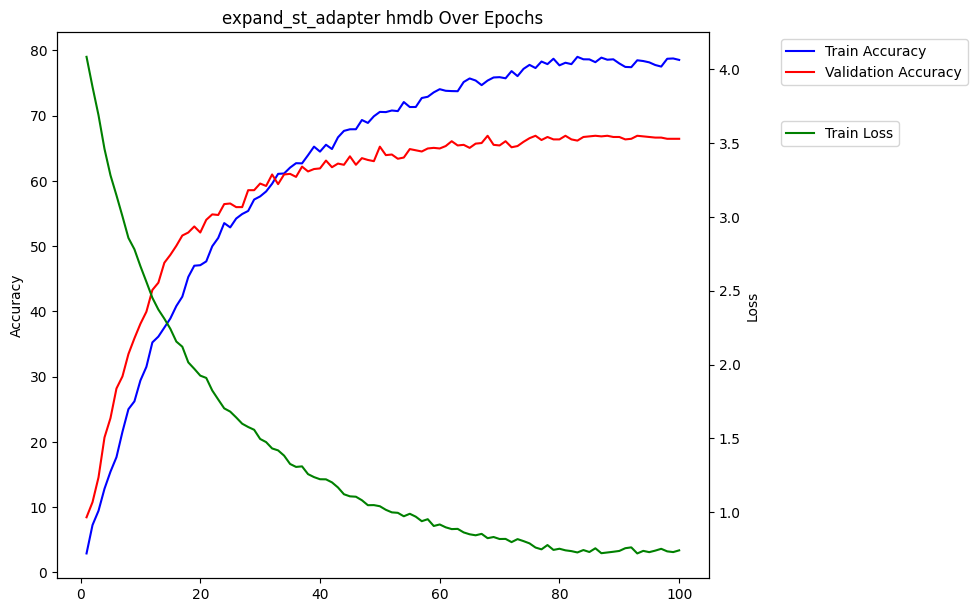

Model_name: expand_st_adapter    Dataset: ucf
Max Train Accuracy: 96.80867666162355 at Epoch 86
Max Validation Accuracy: 98.17073170731707 at Epoch 86
Min Train Loss: 0.11880071480734071 at Epoch 93


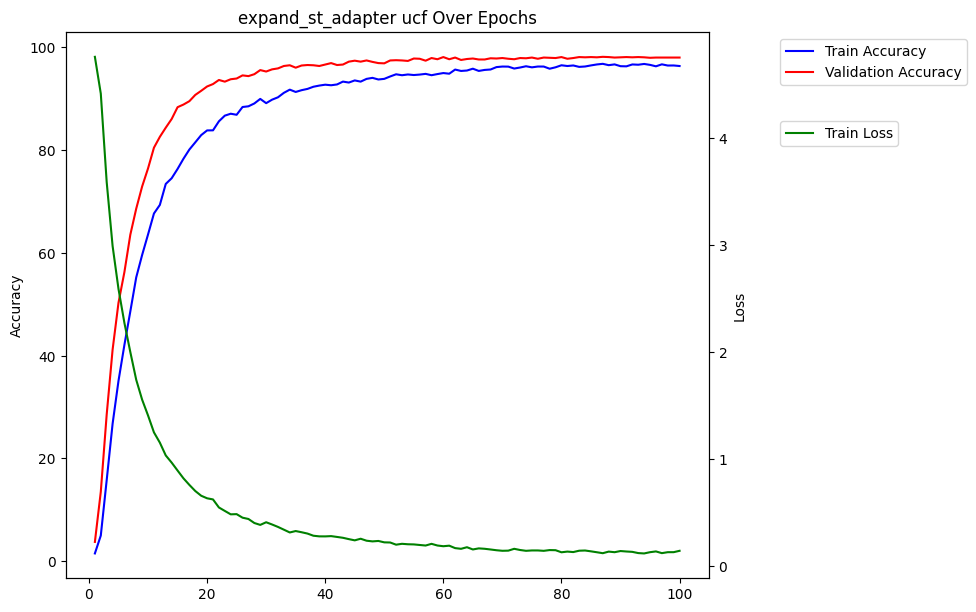

Model_name: expand_st_adapter_span2    Dataset: hmdb
Max Train Accuracy: 15.762633286972648 at Epoch 80
Max Validation Accuracy: 29.28637627432808 at Epoch 82
Min Train Loss: 3.303553468494654 at Epoch 97


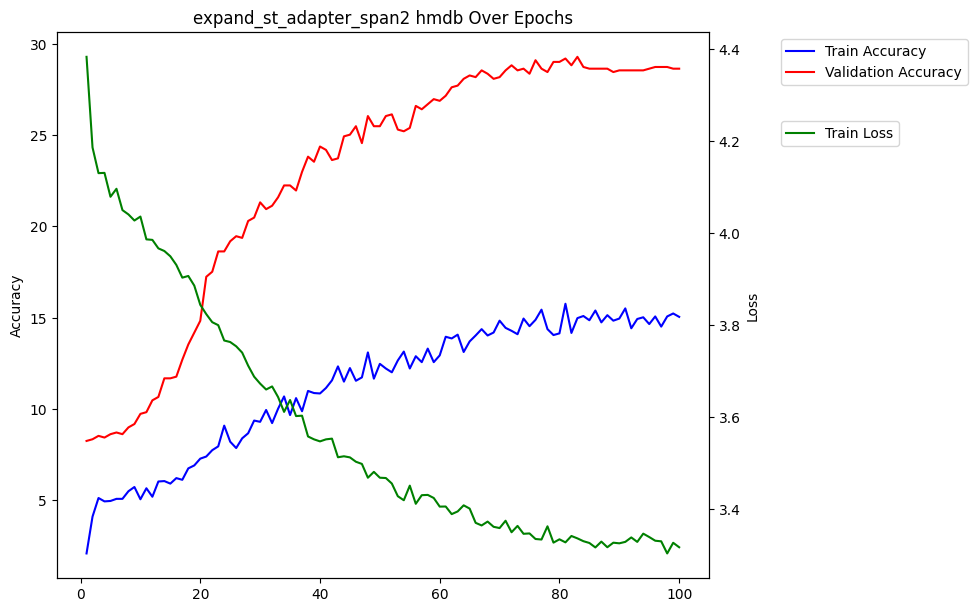

Model_name: expand_st_adapter_span2    Dataset: ucf
Max Train Accuracy: 30.607695917409668 at Epoch 82
Max Validation Accuracy: 56.332082551594745 at Epoch 85
Min Train Loss: 2.851586514937939 at Epoch 99


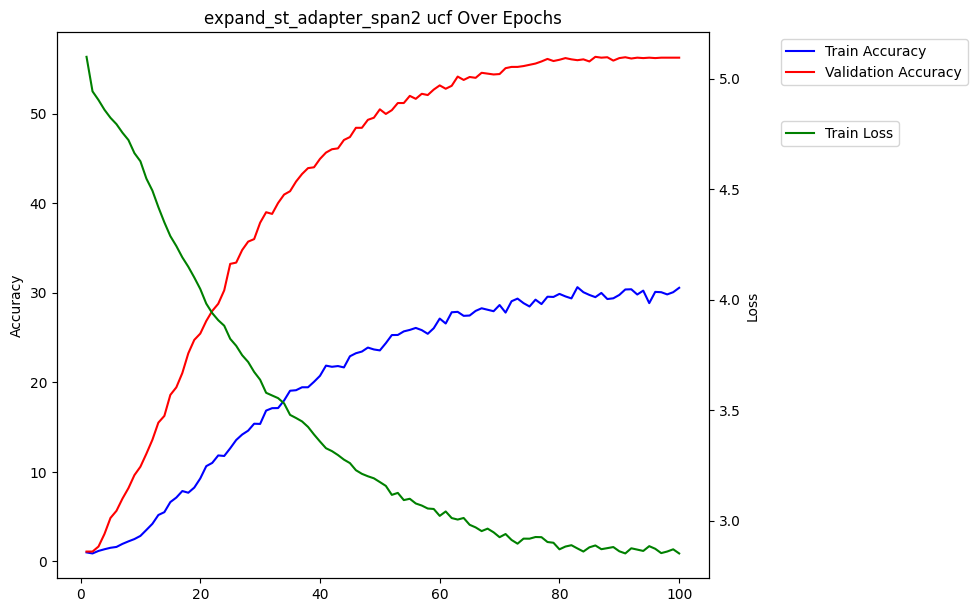

Model_name: expand_st_adapter_difference    Dataset: hmdb
Max Train Accuracy: 62.388888862397934 at Epoch 89
Max Validation Accuracy: 59.22150139017609 at Epoch 97
Min Train Loss: 1.3482118549170317 at Epoch 90


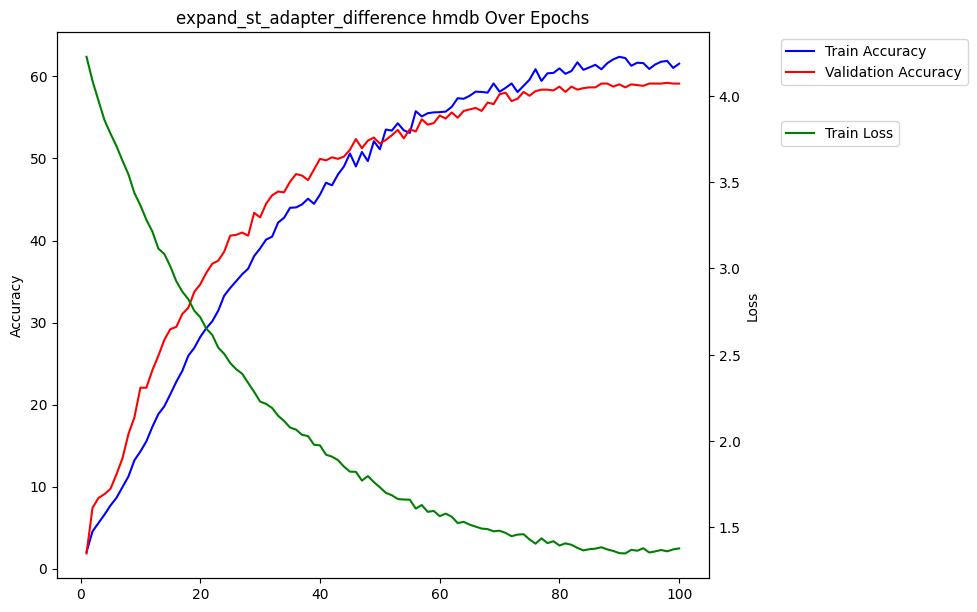

Model_name: expand_st_adapter_difference    Dataset: ucf
Max Train Accuracy: 92.95411985018727 at Epoch 98
Max Validation Accuracy: 94.9343339587242 at Epoch 76
Min Train Loss: 0.27889647096228065 at Epoch 94


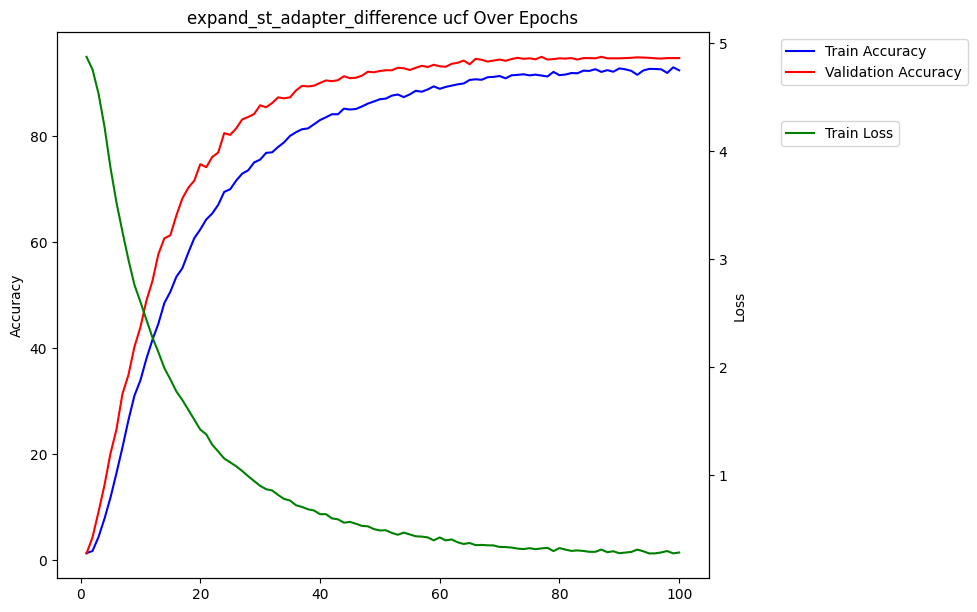

In [52]:
model_names = ['st_adapter', 'expand_st_adapter', 'expand_st_adapter_span2', 'expand_st_adapter_difference']
datasets = ['hmdb', 'ucf']
for model_name in model_names:
    for dataset in datasets:
        get_plt_and_best_epoch(model_name, dataset)

## Compare 4 model

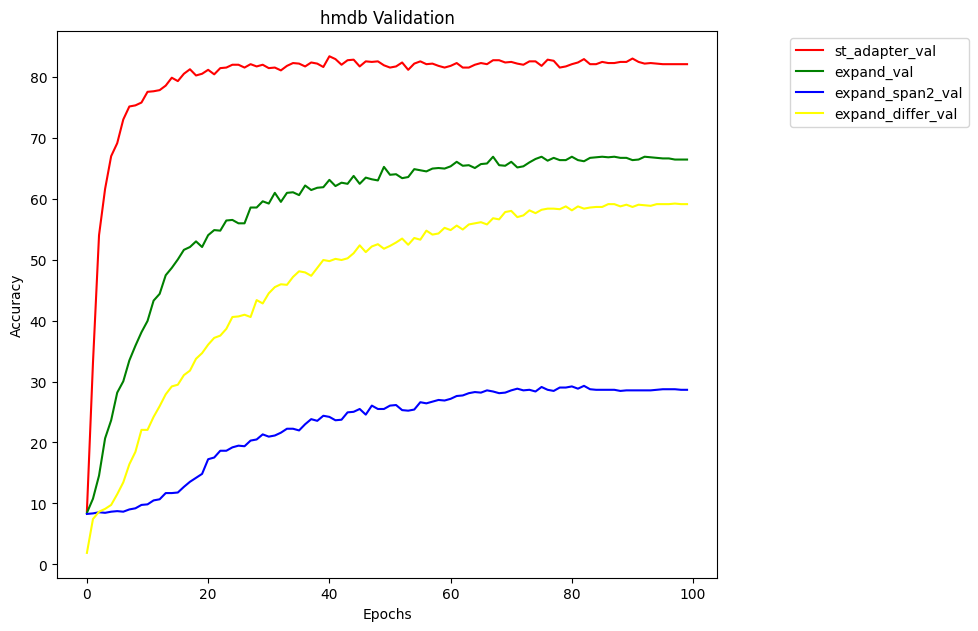

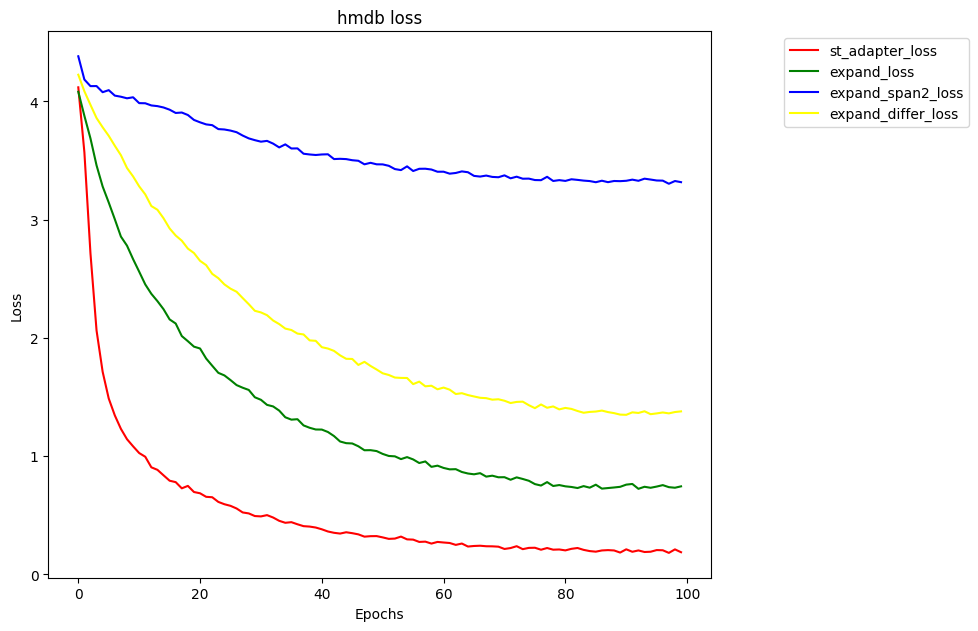

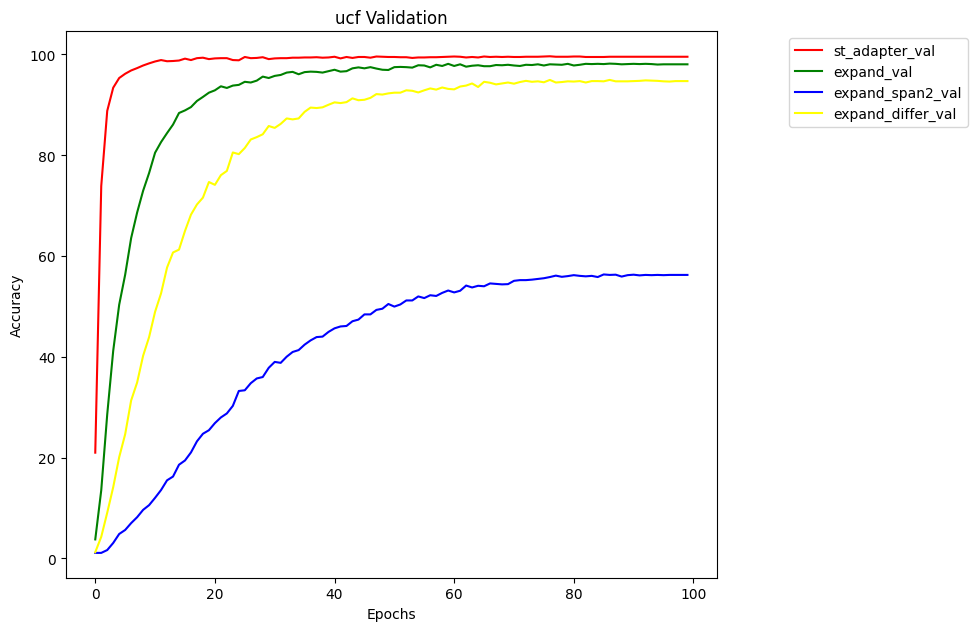

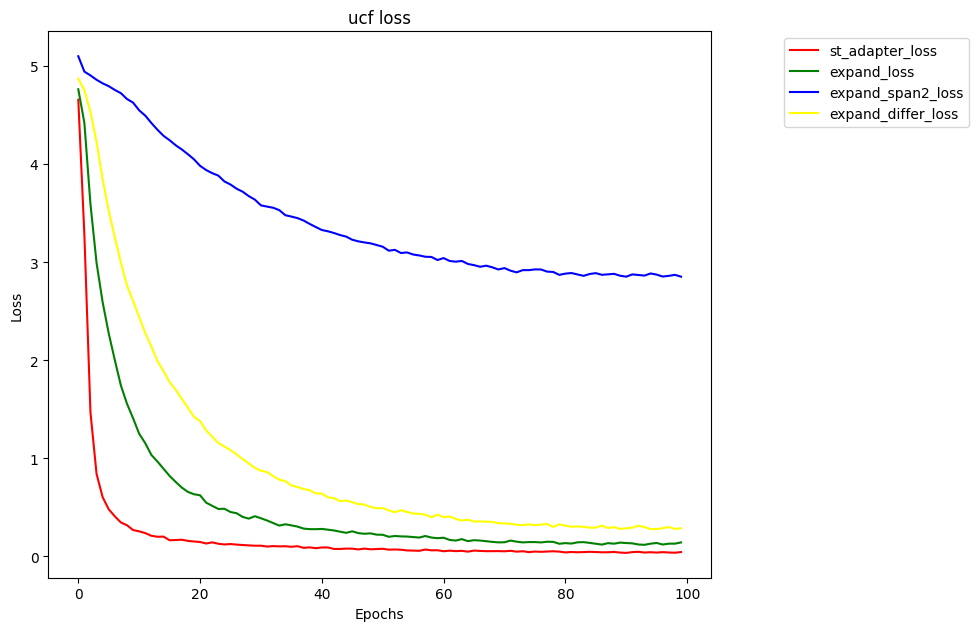

In [13]:
model_names = ['st_adapter', 'expand_st_adapter', 'expand_st_adapter_span2', 'expand_st_adapter_difference']
datasets = ['hmdb', 'ucf']
for dataset in datasets:
    st_adapter_val = []
    expand_val = []
    expand_span2_val = []
    expand_differ_val = []

    st_adapter_loss = []
    expand_loss = []
    expand_span2_loss = []
    expand_differ_loss = []
    for model_name in model_names:
        file_path = f'/hahmwj/expand_tube_st_adapter/trained_weight/{model_name}/{dataset}/log.txt'
        val_acc = []
        train_loss = []
        i = 0
        # 파일 열기
        with open(file_path, 'r', encoding='utf-8') as file:
            # 파일의 각 줄을 순회하면서 데이터 추출
            for line in file:
                # JSON 형식의 라인을 파싱
                data = json.loads(line)

                if i > 99:
                    break
                # 데이터 추출 및 저장
                i+=1
                val_acc.append(data.get("val_acc1"))
                train_loss.append(data.get("train_loss"))
        # model_names = ['st_adapter', 'expand_st_adapter', 'expand_st_adapter_span2', 'expand_st_adapter_difference']
        if model_name == 'st_adapter':
            st_adapter_val = val_acc
            st_adapter_loss = train_loss
        elif model_name == 'expand_st_adapter':
            expand_val = val_acc
            expand_loss = train_loss
        elif model_name == 'expand_st_adapter_span2':
            expand_span2_val = val_acc
            expand_span2_loss = train_loss
        elif model_name == 'expand_st_adapter_difference':
            expand_differ_val = val_acc
            expand_differ_loss = train_loss

    # 그래프 그리기
    epochs = range(0, len(st_adapter_val) )

    # 병렬 그래프
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, st_adapter_val, label='st_adapter_val', color='red')
    plt.plot(epochs, expand_val, label='expand_val', color='green')
    plt.plot(epochs, expand_span2_val, label='expand_span2_val', color='blue')
    plt.plot(epochs, expand_differ_val, label='expand_differ_val', color='yellow')

    # 첫 번째 y 축 레이블 설정
    plt.ylabel('Accuracy', color='black')
    plt.tick_params('y', colors='black')
    # 범례 추가
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.tight_layout()
    # 그래프 제목 및 x 축 레이블 추가
    plt.title(f'{dataset} Validation')
    plt.xlabel('Epochs')

    plt.savefig(f'/hahmwj/expand_tube_st_adapter/trained_weight/Result_plot/compare_by_model/{dataset}_val.png',  bbox_inches='tight')
    # 그래프 표시
    plt.show()

    # 병렬 그래프
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, st_adapter_loss, label='st_adapter_loss', color='red')
    plt.plot(epochs, expand_loss, label='expand_loss', color='green')
    plt.plot(epochs, expand_span2_loss, label='expand_span2_loss', color='blue')
    plt.plot(epochs, expand_differ_loss, label='expand_differ_loss', color='yellow')

    # 첫 번째 y 축 레이블 설정
    plt.ylabel('Loss', color='black')
    plt.tick_params('y', colors='black')
    # 범례 추가
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.tight_layout()
    # 그래프 제목 및 x 축 레이블 추가
    plt.title(f'{dataset} loss')
    plt.xlabel('Epochs')

    plt.savefig(f'/hahmwj/expand_tube_st_adapter/trained_weight/Result_plot/compare_by_model/{dataset}_loss.png',  bbox_inches='tight')
    # 그래프 표시
    plt.show()


In [13]:
ad_checkpoint = torch.load('/hahmwj/expand_tube_st_adapter/trained_weight/expand_st_adapter/hmdb/checkpoint-14.pth', map_location='cpu')
trained_weight = ad_checkpoint['model']
model = models_adapter.expand_st_adapter(
            input_resolution=224,
            patch_size=16,
            width=768,
            layers=12,
            heads=12,
            adapter_width=384,
            adapter_layers=12,
            adapter_kernel_size=(3, 1, 1),
            adapter_pre_attn=False,
            adapter_pre_mlp=True,
            num_classes=51
        )
model.load_state_dict(trained_weight, strict=False)

<All keys matched successfully>

In [17]:
dataframe = pd.read_csv('/hahmwj/csv_files/hmdb.csv')

In [18]:
dataset_test = VideoDataset(
      dataframe,
        'train',
      random_sample=False,
      spatial_size=224,
      num_frames=8,
      sampling_rate=0,
      num_spatial_views=1,
      num_temporal_views=1,
      )
dataset_test = torch.utils.data.DataLoader(
    # torch.utils.data.Subset(dataset_val, range(dist.get_rank(), len(dataset_val), dist.get_world_size())),
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    )

In [19]:
model.cuda()
metric_logger = MetricLogger(delimiter="  ")
header = 'Test:'
for data, labels in dataset_test:
    data, labels = data.cuda(), labels.cuda()
    B, V = data.size(0), data.size(1)
    data = data.flatten(0, 1)
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            logits = model(data)
        scores = logits.softmax(dim=-1)
        scores = scores.view(B, V, -1).mean(dim=1)
        acc1 = (logits.topk(1, dim=1)[1] == labels.view(-1, 1)).sum(dim=-1).float().mean().item() * 100
        acc5 = (logits.topk(5, dim=1)[1] == labels.view(-1, 1)).sum(dim=-1).float().mean().item() * 100
        metric_logger.meters['acc1'].update(acc1, n=scores.size(0))
        metric_logger.meters['acc5'].update(acc5, n=scores.size(0))
    metric_logger.synchronize_between_processes()
    print('* Acc@1 {top1.global_avg:.3f} Acc@5 {top5.global_avg:.3f}'
        .format(top1=metric_logger.acc1, top5=metric_logger.acc5))

* Acc@1 100.000 Acc@5 100.000
* Acc@1 50.000 Acc@5 50.000
* Acc@1 66.667 Acc@5 66.667
* Acc@1 50.000 Acc@5 75.000
* Acc@1 40.000 Acc@5 80.000
* Acc@1 50.000 Acc@5 83.333
* Acc@1 42.857 Acc@5 71.429
* Acc@1 50.000 Acc@5 75.000
* Acc@1 44.444 Acc@5 66.667
* Acc@1 40.000 Acc@5 70.000
* Acc@1 36.364 Acc@5 63.636
* Acc@1 33.333 Acc@5 58.333
* Acc@1 30.769 Acc@5 53.846
* Acc@1 35.714 Acc@5 57.143
* Acc@1 40.000 Acc@5 60.000
* Acc@1 37.500 Acc@5 62.500
* Acc@1 35.294 Acc@5 64.706
* Acc@1 33.333 Acc@5 61.111
* Acc@1 31.579 Acc@5 57.895
* Acc@1 30.000 Acc@5 60.000
* Acc@1 33.333 Acc@5 61.905
* Acc@1 31.818 Acc@5 59.091
* Acc@1 30.435 Acc@5 60.870
* Acc@1 33.333 Acc@5 62.500
* Acc@1 32.000 Acc@5 60.000
* Acc@1 34.615 Acc@5 61.538
* Acc@1 37.037 Acc@5 62.963
* Acc@1 39.286 Acc@5 64.286
* Acc@1 37.931 Acc@5 62.069
* Acc@1 36.667 Acc@5 60.000
* Acc@1 38.710 Acc@5 61.290
* Acc@1 37.500 Acc@5 62.500
* Acc@1 39.394 Acc@5 63.636
* Acc@1 41.176 Acc@5 64.706
* Acc@1 40.000 Acc@5 62.857
* Acc@1 41.667 Acc